In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from src.model.lstm import LSTMClassifier
from src.agnews_dataset import preprocess_data, AGNewsDataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt_path = "model/lstm_2023-12-02_18-07-51.pt"
model_ckpt = torch.load(ckpt_path, map_location=device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = LSTMClassifier(
    vocab_size=len(tokenizer),
    embedding_dim=model_ckpt["model_args"]["embedding_dim"],
    hidden_dim=model_ckpt["model_args"]["hidden_dim"],
    num_layers=model_ckpt["model_args"]["num_layers"],
    output_dim=model_ckpt["model_args"]["output_dim"],
    dropout=model_ckpt["model_args"]["dropout"],
).to(device)
model.load_state_dict(model_ckpt["state_dict"])

model

LSTMClassifier(
  (embedding): Embedding(30522, 256)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [3]:
embedding_model = nn.Sequential(*list(model.children())[:-2])
embedding_model.eval()
embedding_model

Sequential(
  (0): Embedding(30522, 256)
  (1): LSTM(256, 256, batch_first=True, bidirectional=True)
)

In [4]:
# Load test data
data_path = "data/test.csv"

text, label = preprocess_data(data_path)
test_encodings = tokenizer(
    text,
    truncation=True,
    padding=True,
    max_length=model_ckpt["model_args"]["max_length"],
)

test_dataset = AGNewsDataset(test_encodings, label)
test_dataloader = DataLoader(test_dataset, batch_size=32)

print(len(test_dataset))

7600


In [5]:
embeddings = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        _, (hidden, _) = embedding_model(batch["input_ids"])
        hidden = hidden[-1]
        embeddings.extend(hidden.cpu().numpy())

embeddings = np.array(embeddings)

In [6]:
embeddings_2d = TSNE(
    n_components=2, random_state=model_ckpt["model_args"]["seed"]
).fit_transform(embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
embeddings_2d.shape

(7600, 2)

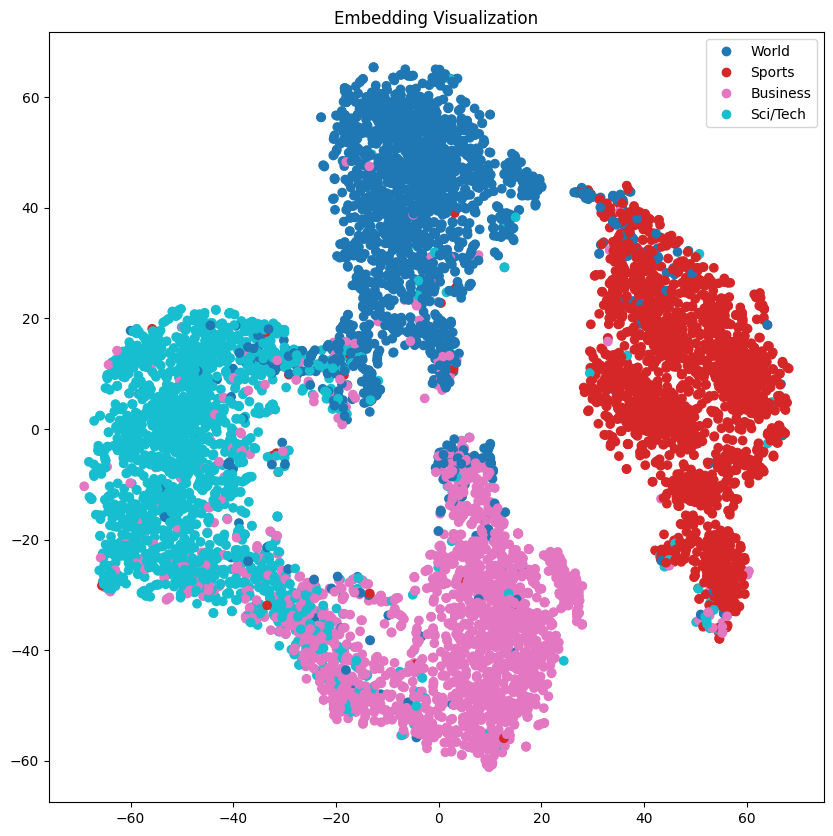

In [23]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=label, cmap="tab10")
plt.legend(handles=scatter.legend_elements()[0], labels=label_names)
plt.title("Embedding Visualization")
plt.savefig("embedding_visualization.png")
plt.show()